In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from datetime import datetime
import pandas as pd
from gekko import GEKKO
df = pd.read_csv('Parsed.csv')
BG = df['Blood Glucose (mg/dL)']
BG = BG.dropna().values

# For m in [mhe, sim]
#minutes run
N = int(180) #minutes in 3 hours
h = int(3) #number of time horizons
H = int(N*h)
dt = 1  # (min) timespacing
m = GEKKO()

# TODO Find optimal control horizon to account for disturbances especially
m.time = np.linspace(0, N, N+1)  # Three hour moving horizon

# Params
bg = m.Param(291.0, name='bg')  # (mg/dL) Basal Blood Glucose
p1 = m.Param(3.17e-2, name='p1')   # (1/min)
p2 = m.Param(1.23e-2, name='p2')   # (1/min)
# si = m.Param(2.9e-2)    # (1/min * (mL/micro-U))
ke = m.Param(9.0e-2)    # (1/min) Insulin elimination from plasma
kabs = m.Param(1.2e-2)  # (1/min) t max,G inverse
kemp = m.Param(1.8e-1)  # (1/min) t max,I inverse
f = m.Param(8.00e-1)    # (L)
vi = m.Param(12.0)      # (L)     Insulin distribution volume
vg = m.Param(12.0)      # (L)     Glucose distibution volume

final = np.zeros_like(m.time)
final[-1] = 1
fin = m.Param(final)

# FV
# TODO implement good bounds on these
# TODO Bounds on possible levels

si = m.FV(2.9e-2, lb=0.01, ub=1)    # (1/min * (mL/micro-U))
D  = m.MV(0, lb=0, ub=4000)      # Disturbance (mmol/L min)
# storage arrays
si_ = np.zeros(H)
D_  = np.zeros(H)
G_  = np.zeros(H)
Ob_ = np.zeros(H)
U_  = np.zeros(H)

# Vars
# TODO: Initial Values
G = m.CV(BG[0], fixed_initial=True, lb=10, ub=400)    # (mg/dL) Blood Glucose
X = m.Var(1,)      # (μu/ml) Remote Insulin
I = m.Var(1,)      # (μu/ml) Plasma Insulin
U = m.MV(.024,fixed_initial=True, lb=0)       # (mU/min) Insulin Delivery
GG = m.Var(1,)     # (mg/dL) Gut insulin

S1 = m.Var()     # Subcutaneous storage
S2 = m.Var()     # Intermediate 2

# obj = m.Var(0)

# Equations
m.Equations([
    G.dt()/dt == -p1 * (G-bg) - si * X * G + f * kabs / vg * GG + f / vg * D,  # Dynamic Insulin Rate
    X.dt()/dt == p2 * (I - X),                                                 # Remote Insulin dynamics
    I.dt()/dt == -ke * I + U,                                                  # Plasma Insulin Concentration
    S1.dt()/dt == U - kemp * S1,                                               # Dynamic Model
    S2.dt()/dt == -kemp * (S2 - S1),                                           # Dynamic Model
    GG.dt()/dt == kemp * S2 - kabs * GG,
#     obj.dt() == m.if3(G-lb, -1 * lm, m.if3(ub-g, -1, 1.0 - m.tanh(m.abs3((G-target)/slope)*0.1)**2)) # m.integral(print(reward_func(G)[0]))
])

## Tuning
si.STATUS = 1; si.FSTATUS = 0
D.STATUS  = 1; D.FSTATUS  = 0
D.DCOST=.001


G.STATUS  = 0; G.FSTATUS  = 1
U.STATUS  = 0; U.FSTATUS  = 1

## Global options
m.options.IMODE   = 5
m.options.EV_TYPE = 2

# m.Maximize(obj * fin)MHE

In [15]:
df = pd.read_csv('Parsed.csv')
df_dense = df.dropna()

i=0
for date, time, glucose, insulin in df.itertuples(index=False):
    if not np.isnan(glucose):
        G.MEAS = glucose
#     else:
#         G.MEAS = G.value

    U.MEAS = insulin
    # solve with MHE
#     print(G,U)
    m.solve(disp=False)
    # Store MHE values for basal glucose rate and disturbances
#     print(f'{si.NEWVAL=}')
#     print(f'{D.NEWVAL=}')
#     print(f'{G.MODEL=} vs {glucose}')
#     print(f'{U.NEWVAL=}')
#     print(f'{m.options.OBJFCNVAL}\n')
    si_[i] = si.NEWVAL
    D_[i]  = D.NEWVAL
    U_[i]  = U.NEWVAL
    G_[i]  = G.MODEL
    Ob_[i] = m.options.OBJFCNVAL
    i += 1

IndexError: index 540 is out of bounds for axis 0 with size 540

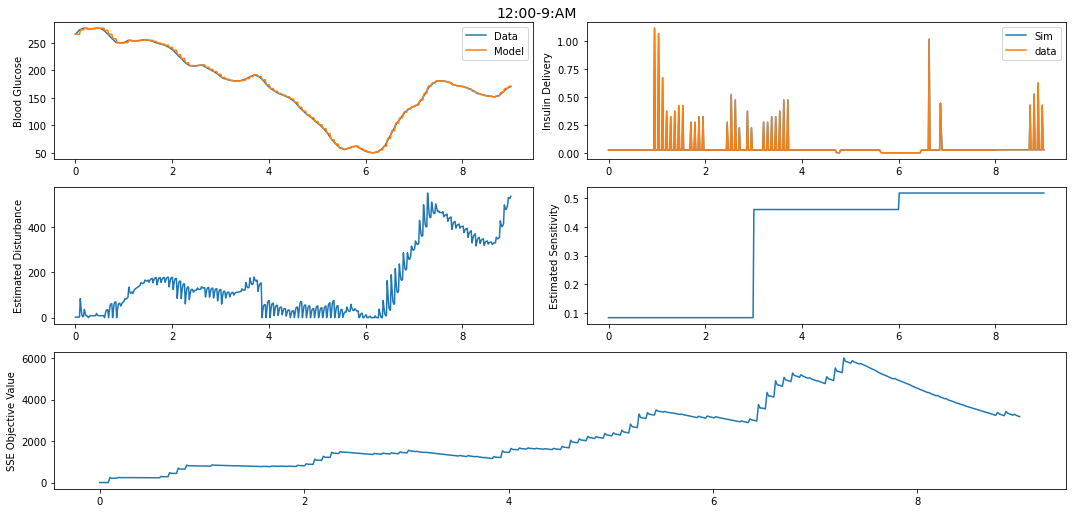

In [49]:
n = int(N/5*h)
t = np.linspace(0,1,n)*m.time[-1]*h/60
t_= np.linspace(0,1,N*h)*m.time[-1]*h/60
BG = df['Blood Glucose (mg/dL)']
BG = BG.dropna()

plt.figure(figsize=(15,14))
fig = plt.gcf()
fig.suptitle("12:00-9:AM", fontsize=14)
plt.subplot(621)
plt.plot(t, BG[:n], label='Data')
plt.plot(t_,G_, label='Model')
plt.ylabel('Blood Glucose')
plt.legend()

plt.subplot(622)
# plt.plot(m.time,I)
# plt.plot(m.time,X)
# plt.plot(m.time,GG)
plt.plot(t_,U_,label='Sim')
plt.plot(t_,df['Insulin Delivery (IU) '][:H], label='data')
plt.ylabel('Insulin Delivery')
plt.legend()

plt.subplot(623)
plt.plot(t_,D_)
plt.ylabel('Estimated Disturbance')

plt.subplot(624)
s = np.zeros_like(si_)
s[:180] = si_[180]
s[180:360] = si_[360]
s[360:] = si_[-1]
plt.plot(t_,s)
plt.ylabel('Estimated Sensitivity')

plt.subplot(613)
plt.plot(t_,Ob_)
plt.ylabel('SSE Objective Value')
plt.tight_layout()

plt.savefig('Midnight-9AM.png')

45644


Index(['Date', 'Time', 'Blood Glucose (mg/dL)', 'Insulin Delivery (IU) '], dtype='object')

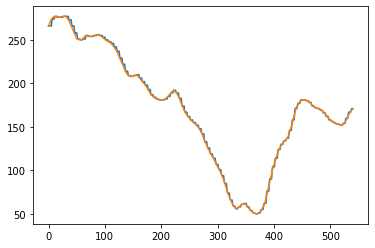

In [17]:
t0 = np.linspace(0,1,n)*m.time[-1]*h
plt.plot(t_,G_)
plt.plot(t0, BG[:n], label='Data')
T = df['Time']
Tn = np.zeros_like(T)
for i in range(len(T)):
    pt = datetime.strptime(T[i],'%H:%M:%S')
    A  = pt.minute+pt.hour*60
    Tn[i] = A
print(len(Tn))
df.columns


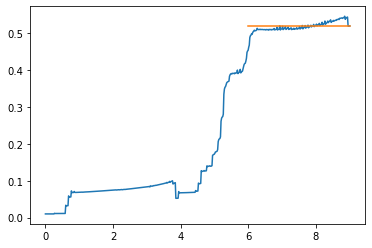

In [41]:
plt.plot(t_,si_)
plt.plot((360+m.time)/60,si)